In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import scipy.io
import random

# Extract SIFT features and save them in mat 

In [2]:
def get_features(image,set_no,top_features,image_no):
    
    print("Set no ",set_no)
    print("Image no ",image_no)
    print("Top ",top_features," will be selected")
    
    sift = cv2.SIFT_create(top_features)
    keypoints, descpriptors = sift.detectAndCompute(image,None)
    
    sift_image=cv2.drawKeypoints(image,random.sample(keypoints,200),np.array([]),flags= cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color= (0, 255, 255) )
    plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
    plt.title("Image with 200 SIFT KeyPoints")
   
    plt.show()
    
    image_descriptors=descpriptors[:top_features,:]
    image_features=np.zeros((4,top_features))
    
    for i in range(top_features):
        image_features[:,i]=np.array([keypoints[i].pt[0],keypoints[i].pt[1],keypoints[i].size,keypoints[i].angle])
    
    img_des = 'results'+ "/Set" + str(set_no) + "/mat files/" + "d"+ str(image_no) + "_set" + str(set_no) + ".mat"
    img_feat= 'results'+ "/Set" + str(set_no) + "/mat files/" + "f"+ str(image_no) + "_set" + str(set_no) + ".mat"
    
    
    print("Saving SIFT features for "+ "Image"+ str(i) + "...")
    scipy.io.savemat(img_des , {'array': image_descriptors})
    scipy.io.savemat(img_feat, {'array': image_features   })
      
    
    
    

# Match Features Using NNDR

In [3]:
def find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches=30):
    
    
    print("\nSet = Set" + str(set_n))
    print("From Image"+str(i_from) + " & To Image" + str(i_to))

    print("\nFrom Image:")
    print("Loading " +  "f" + str(i_from) + "_set" + str(set_n) + ".mat ..." )
    print("Loading " +  "d" + str(i_from) + "_set" + str(set_n) + ".mat ..." )
  
    from_img_feats= scipy.io.loadmat('results/'+ "Set" + str(set_n) + "/mat files/" + "f"+ str(i_from) + "_set" + str(set_n) + ".mat")['array']
    from_img_des  = scipy.io.loadmat('results/'+ "Set" + str(set_n) + "/mat files/" + "d"+ str(i_from) + "_set" + str(set_n) + ".mat")['array']
  
    
    print("\nTo Image:")
    print("Loading " +  "f" + str(i_to) + "_set" + str(set_n) + ".mat ..." )
    print("Loading " +  "d" + str(i_to) + "_set" + str(set_n) + ".mat ..." )
    
    to_img_feats= scipy.io.loadmat('results/'+ "Set" + str(set_n) + "/mat files/" + "f"+ str(i_to) + "_set" + str(set_n) + ".mat")['array']
    to_img_des  = scipy.io.loadmat('results/'+ "Set" + str(set_n) + "/mat files/" + "d"+ str(i_to) + "_set" + str(set_n) + ".mat")['array']
  

    print("\nThere are " + str(len(to_img_des)) + " SIFT descriptors/keypoints in each image.")

    closest_neighbors = np.zeros((len(from_img_des),2) , dtype=np.int64 )  # Reference to Target Image Descriptors Distances:    [ Index_NearestNeighbor      Index_2nd NearestNeighbors]
    NNDR              = np.zeros((len(from_img_des)  ))                    # NNDR  distance_nearest_neighbor / distance_2nd_nearest_neighbor


    distance_array= np.zeros((len(to_img_des)))

    #for i in range(len(img_des)):         # Loop over descriptors of 1st image

    print("\nFinding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...")
    
    for i in range(len(from_img_des)):      # Loop over descriptors of 'From' image

        for j in range(len(to_img_des)):     # Loop over descriptors of 'To' image
            # l2 distance between ith descriptor of 1st image and jth descriptor of 2nd image
            distance_array[j] = np.linalg.norm( (from_img_des[i]-to_img_des[j]) )

        # Two indices corresponding to closest and 2nd closest neighbors respectively
        #top_ind = distance_array.argsort()[-2:][::-1]
        top_ind=np.argpartition(distance_array, 2)[:2]
        

        d_b = distance_array[top_ind[0]]    # closest distance , nearest
        d_c = distance_array[top_ind[1]]    # 2nd closest distance , 2nd nearest
        nndr = d_b/d_c                      # NNDR = d1/d2 = |D_A - D_B|/|D_A - D_C| =  nearest / 2nd nearest

        #                          Nearest      2nd Nearest 
        closest_neighbors[i,:] = np.array([ top_ind[0] , top_ind[1] ])
        NNDR[i]= nndr                          








    plt.figure()
    plt.plot(NNDR)
    plt.title("Nearest Neighbor Distance Ratio")
    plt.show()


    # Good neighbors are those keypoints in Image2 where NNDR<threshold
    good_neighbors = closest_neighbors[NNDR<0.8]


    print("Finding good keypoints based on NNDR ...")
    # Good keypoints are the points where NNDR is less than threshold
    from_good_kpts  = from_img_feats[ :, NNDR<0.8]              # 1st Image : From Image
    to_good_kpts    = to_img_feats[ :, good_neighbors[:,0] ]    # 2nd Image : To  Image  , choose a keypoint that is nearest to corresponding keypoint in 1st image


    print("Drawing good matches from Image" + str(i_from) + " to Image" + str(i_to) + "...")
    # Concatenating Image1 and Image2
    new_img = np.concatenate(  (to_img, from_img) , axis=1    )

    

    for i in range(top_select_matches):

        # Start Point on "From Image"
        from_point = ( int( from_good_kpts[0,i])+to_img.shape[1]   , int(from_good_kpts[1,i])     )
        
        # End Point on "To Image"
        to_point =   (   int( to_good_kpts[0,i])                     , int(to_good_kpts[1,i])     )
        
        cv2.line(new_img , from_point , to_point , color=(255,0,0), thickness=2)


    plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    plt.title("First " + str(top_select_matches) + " NNDR Matches\n " + "Set" + str(set_n) + ": To Image" + str(i_to) + " vs. From Image" + str(i_from))  
    plt.show() 
    
     
    print("\nDone.\n\n")

    return from_good_kpts , to_good_kpts

# Transformation Recovery

In [13]:
def get_AffineTransformation(Image1, Image2,  locs_1, locs_2):
    
    
    # Construct A matrix from selected locations of original image
    A= np.zeros((2*locs_1.shape[0], 6))

    for count, i in enumerate(range(0, A.shape[0], 2)):

        A[i,:]=   np.concatenate((locs_1[count,:], np.array([1,0,0,0])) , axis=0 )
        A[i+1,:]= np.concatenate(( np.array([0,0,0]) , locs_1[count,:] , np.array([1]) ) , axis=0 )

        
    # Getting y vector from corresponding locations in transformed image    
    y= locs_2.reshape((-1,1))

    
    # Getting transformation matrix
    A_pinv =  np.linalg.pinv(A)
    x= np.matmul(A_pinv,y)
    T = x.reshape(2,3) # transformation matrix
    
    
    # Applying affine transformation on original image
    T_Image= cv2.warpAffine( Image1, T , (Image2.shape[1], Image2.shape[0]  ) )
    
    
    
    # Getting MSE between intensities of Image2 and transformed image
    MSEPix= np.mean( (T_Image-Image2)**2 )
    
    
    # Getting MSE between corresponding locations of Image2 and transformed locations
    T_points= np.matmul(T,  np.vstack( (locs_1.T, np.ones((1, locs_1.T.shape[1]))) ))
    MSECorPts = np.mean( (T_points-locs_2.T)**2 )
    
    
    return MSEPix, MSECorPts, T, T_Image

def get_PerspectiveTransformation(from_points , to_points):
    
    num_points = from_points.shape[1]


    to_points_vec   = to_points.reshape((-1,1))   # array (2*num_points , 1) 

    from_points_vec = from_points.reshape((-1,1)) # array (2*num_points , 1) 



    left_corner = np.concatenate((-1*from_points.T ,-1*np.ones(( len(to_points_vec)//2,1))),axis=1)

    left_block  = np.vstack(( left_corner ,np.zeros((left_corner.shape))) )

    mid_block   = np.vstack( ( np.zeros((left_corner.shape)) ,  left_corner ) )


    from_to_prod = from_points.T*(-1*to_points_vec[:(len(to_points_vec)//2)])
    to_from_prod = from_points.T*(-1*to_points_vec[(len(to_points_vec)//2):])



    right_block = np.vstack((from_to_prod, to_from_prod)  )


    P = np.concatenate( ( np.concatenate((left_block, mid_block ), axis=1) , right_block ) , axis=1)

    h = np.matmul(np.linalg.pinv(P), -1*to_points_vec)

    H = np.zeros( (3,3))
    H[0,:]   = h[0:3 , 0]
    H[1,:]   = h[3:6 , 0]
    H[2, 0:2]= h[6:8 , 0]
    H[2,2]=1

    return H





# RanSAC

In [14]:
def ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans ):

    print("RANSAC : No. of Iterations = " , str(iters))
    print("Selecting 3 random points from good keypoints in each iteration...")
    print("Searching for maximum number of inliers ...")

    # Number of Inliers
    max_inliers= 0

    for itr in range(iters):

        # Select three random points
        random_ind= np.random.randint(0 , from_good_kpts.shape[1]-1, 3)

        random_points_from = from_good_kpts[0:2 , random_ind]
        random_points_to = to_good_kpts[0:2 , random_ind]


        if( trans == "Affine"):
            MSEPix, MSECorPts, T, T_Image = get_AffineTransformation(from_img, to_img,  random_points_from.T, random_points_to.T)
            transformed_cords = np.matmul(T,  np.vstack( (from_good_kpts[0:2,:] , np.ones((1, from_good_kpts[0:2,:].shape[1]))) ))

        if( trans == "Perspective"):
            T = get_PerspectiveTransformation(random_points_from, random_points_to)
            transformed_cordss = np.matmul(T,  np.vstack( (from_good_kpts[0:2,:] , np.ones((1, from_good_kpts[0:2,:].shape[1]))) ))
            transformed_cords  =  transformed_cordss[0:2,:]/transformed_cordss[2,:]
        
        

        norm = np.linalg.norm( transformed_cords- to_good_kpts[0:2, :] , axis=0 )

        bools = np.where(norm < 3 , 1, 0)
        n_inliers = bools.sum()
        

        if (n_inliers > max_inliers):

            max_inliers = n_inliers
            best_kpts_from   = from_good_kpts[0:2 , norm < 3]
            best_kpts_to     = to_good_kpts[0:2 , norm < 3]
            best_T           = T


    print("Maximum Number of Inliers : " , max_inliers)  
    
    if( trans == "Affine"):
        print("\nBest Affine Transformation \n", best_T)        
        print("\nUsing maximum number of max inliers to recover affine transformation ...")        
        MSEPix, MSECorPts, T, T_Image = get_AffineTransformation(from_img, to_img,  best_kpts_from.T, best_kpts_to.T)        
        print("\nAffine Transformation Obtained from Maximum Inliers \n", T)
        
    
    if(trans == "Perspective"):
        print("\nBest Perspective Transformation \n", best_T)        
        print("\nUsing maximum number of max inliers to recover Perspective transformation ...")        
        T = get_PerspectiveTransformation(best_kpts_from, best_kpts_to) 
        print("\nPerspective Transformation Obtained from Maximum Inliers \n", T)
        
 
    
    new_img = np.concatenate(  (to_img, from_img) , axis=1    )

    for i in range(select_best_matches):

        point_to =   ( int( best_kpts_to[0,i])                    , int(best_kpts_to[1,i])     )
        point_from = ( int( best_kpts_from[0,i])+to_img.shape[1]   , int(best_kpts_from[1,i])     )

        cv2.line(new_img , point_to , point_from , color=(255,0,0), thickness=2)

    plt.figure()
    plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    plt.title("First " + str(select_best_matches) + " RANSAC Best Matches\n " + "Set" + str(set_n) + ": ToImage" + str(i_to) + " vs. FromImage" + str(i_from))
    plt.show()
    
    
    print("\nDone.\n\n")
    
    return T

# Make Panorama

In [30]:
def make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to , trans="Perspective"):
        
    
    if( trans == "Affine"):
        # Warping Image2 with Affine Transformation
        warped = cv2.warpAffine(from_img , T , ( to_img.shape[1]+from_img.shape[1] , to_img.shape[0] ) )
        
    if( trans == "Perspective"):
        # Warping Image2 with Affine Transformation
        warped = cv2.warpPerspective(from_img , T , ( to_img.shape[1]+from_img.shape[1] , to_img.shape[0] ) )
            
    
    warped[0:to_img.shape[0] , 0:to_img.shape[1],: ] = to_img

           
    # Picking Maximum Pixel Intensity in Overlapping Area of Image1 and Warped_Image2
    #warped[0:to_img.shape[0] , 0:to_img.shape[1] , :] = np.maximum(to_img , warped[0:to_img.shape[0] , 0:to_img.shape[1] , :])

    plt.figure()
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
   
    plt.title("Panorama: Set" + str(set_n) + ": To Image"+ str(i_to) + " & From Image"+ str(i_from))
    plt.show()
    return warped
    

# Set 1

Set no  1
Image no  1
Top  1000  will be selected


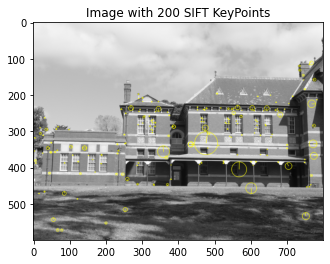

Saving SIFT features for Image999...
Set no  1
Image no  2
Top  1000  will be selected


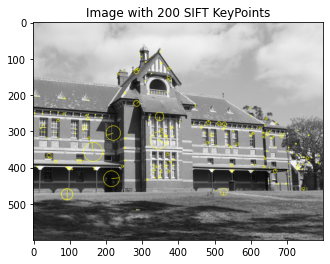

Saving SIFT features for Image999...


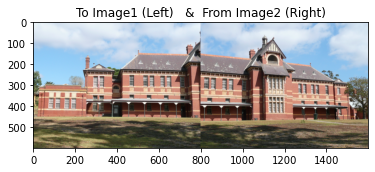


Set = Set1
From Image2 & To Image1

From Image:
Loading f2_set1.mat ...
Loading d2_set1.mat ...

To Image:
Loading f1_set1.mat ...
Loading d1_set1.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


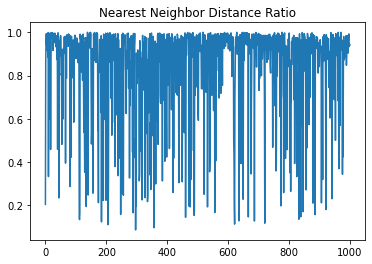

Finding good keypoints based on NNDR ...
Drawing good matches from Image2 to Image1...


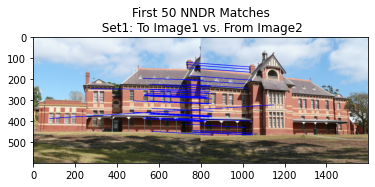


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  114

Best Affine Transformation 
 [[ 9.72284026e-01  1.64273036e-02  5.04218347e+02]
 [-4.21069735e-02  1.00203570e+00 -9.83506814e+00]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 9.77523314e-01  2.44443390e-02  5.00585569e+02]
 [-4.35436253e-02  1.00283015e+00 -9.68123514e+00]]


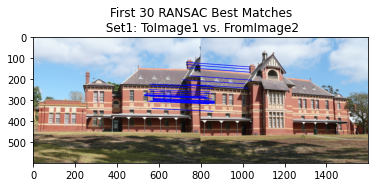


Done.




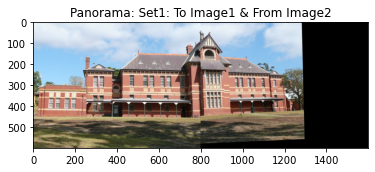

In [31]:
set_n= 1

path_1="results/Set1/image1.jpg"
path_2="results/Set1/image2.jpg"

image_1 = cv2.cvtColor(  cv2.imread(path_1), cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(  cv2.imread(path_2), cv2.COLOR_BGR2GRAY)


get_features(image_1,set_n, 1000, 1)
get_features(image_2, set_n,1000, 2)


image_2=cv2.imread(path_2)
image_1=cv2.imread(path_1)

i_from = 2# From Image
i_to   = 1   # To Image

trans="Affine"
top_select_matches=50


from_img = image_2
to_img = image_1

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)

# Set 2

Set no  2
Image no  1
Top  1000  will be selected


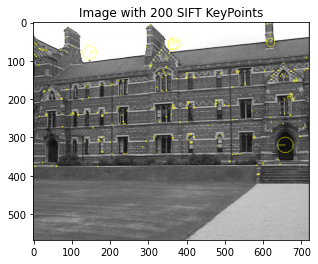

Saving SIFT features for Image999...
Set no  2
Image no  2
Top  1000  will be selected


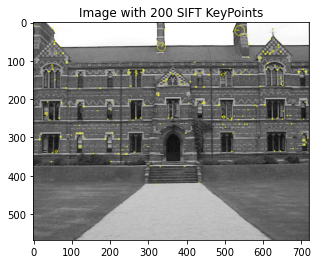

Saving SIFT features for Image999...
Set no  2
Image no  3
Top  1000  will be selected


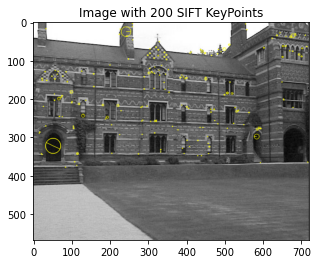

Saving SIFT features for Image999...


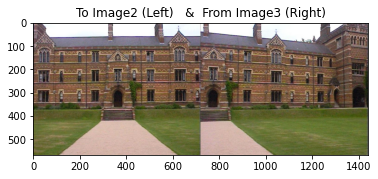


Set = Set2
From Image3 & To Image2

From Image:
Loading f3_set2.mat ...
Loading d3_set2.mat ...

To Image:
Loading f2_set2.mat ...
Loading d2_set2.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


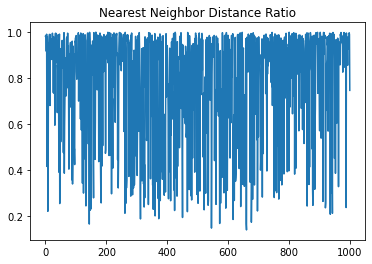

Finding good keypoints based on NNDR ...
Drawing good matches from Image3 to Image2...


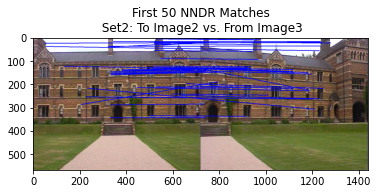


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  137

Best Affine Transformation 
 [[ 9.94244845e-01  3.01210101e-02  3.00365287e+02]
 [-6.82414073e-02  1.02992306e+00  8.33344595e+00]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 9.96990820e-01  2.98953540e-02  3.00070799e+02]
 [-7.07156895e-02  1.03129536e+00  8.62287329e+00]]


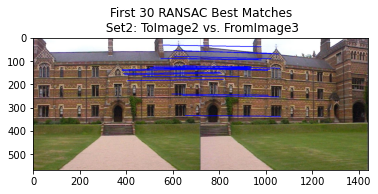


Done.




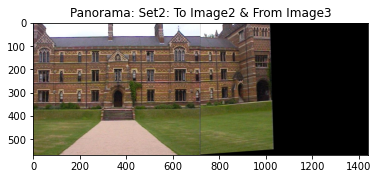

Set no  2
Image no  23
Top  1000  will be selected


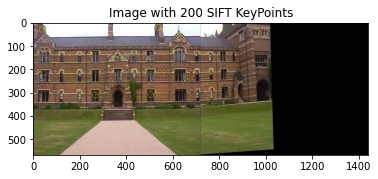

Saving SIFT features for Image999...


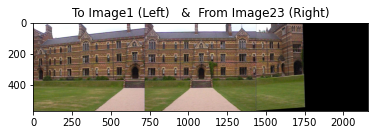


Set = Set2
From Image23 & To Image1

From Image:
Loading f23_set2.mat ...
Loading d23_set2.mat ...

To Image:
Loading f1_set2.mat ...
Loading d1_set2.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


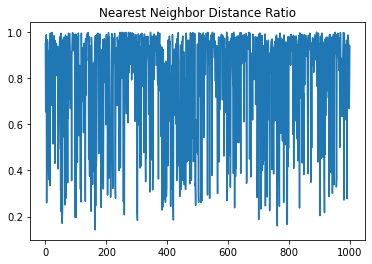

Finding good keypoints based on NNDR ...
Drawing good matches from Image23 to Image1...


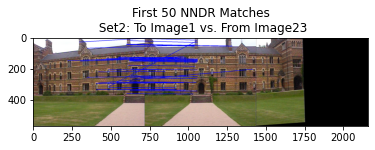


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  129

Best Affine Transformation 
 [[ 1.03657664e+00  1.78345374e-02  2.72696875e+02]
 [-5.43946599e-02  1.02526306e+00  5.31637759e+00]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 1.03984405e+00  2.28300091e-02  2.70993671e+02]
 [-5.51176059e-02  1.02406660e+00  6.43436945e+00]]


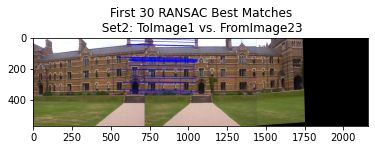


Done.




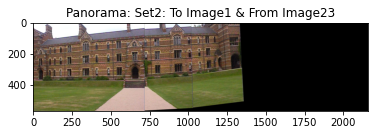

In [38]:
set_n= 2

path_1="results/Set2/image1.jpg"
path_2="results/Set2/image2.jpg"
path_3="results/Set2/image3.jpg"

image_1 = cv2.cvtColor(  cv2.imread(path_1), cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(  cv2.imread(path_2), cv2.COLOR_BGR2GRAY)
image_3 = cv2.cvtColor(  cv2.imread(path_3), cv2.COLOR_BGR2GRAY)


get_features(image_1,set_n, 1000, 1)
get_features(image_2, set_n,1000, 2)
get_features(image_3, set_n,1000, 3)


image_2=cv2.imread(path_2)
image_1=cv2.imread(path_1)
image_3=cv2.imread(path_3)

i_from = 3# From Image
i_to   = 2   # To Image

trans="Affine"
top_select_matches=50


from_img = image_3
to_img = image_2

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)
#########################-------------------other half-----------------###################################
i_from = 23# From Image
i_to   = 1   # To Image

get_features(warped,set_n, 1000, 23)
trans="Affine"
top_select_matches=50


from_img = warped
to_img = image_1

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)

# Set 3

Set no  3
Image no  1
Top  1000  will be selected


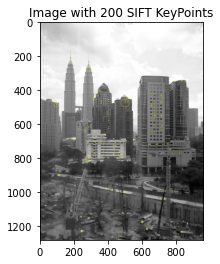

Saving SIFT features for Image999...
Set no  3
Image no  2
Top  1000  will be selected


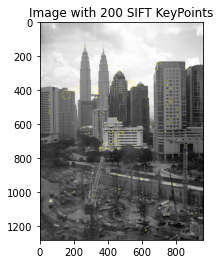

Saving SIFT features for Image999...
Set no  3
Image no  3
Top  1000  will be selected


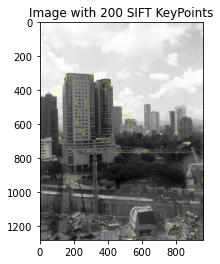

Saving SIFT features for Image999...
Set no  3
Image no  4
Top  1000  will be selected


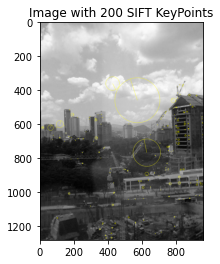

Saving SIFT features for Image999...
Set no  3
Image no  5
Top  1000  will be selected


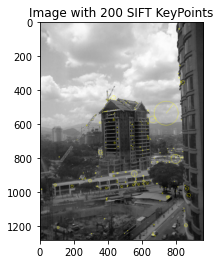

Saving SIFT features for Image999...


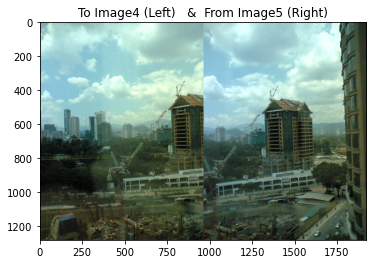


Set = Set3
From Image5 & To Image4

From Image:
Loading f5_set3.mat ...
Loading d5_set3.mat ...

To Image:
Loading f4_set3.mat ...
Loading d4_set3.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


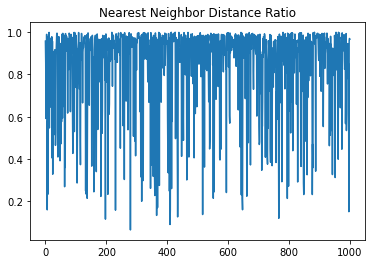

Finding good keypoints based on NNDR ...
Drawing good matches from Image5 to Image4...


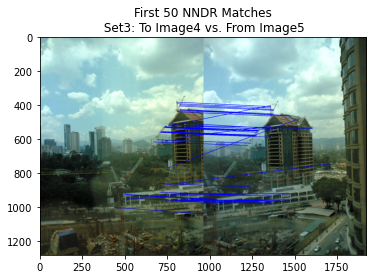


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  117

Best Affine Transformation 
 [[ 1.02250941e+00  8.26671294e-04  4.02872931e+02]
 [ 1.52567079e-02  1.01851043e+00 -3.85060207e+01]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 1.02722737e+00  5.58326612e-04  4.01166605e+02]
 [ 1.00840875e-02  1.01989939e+00 -3.76064753e+01]]


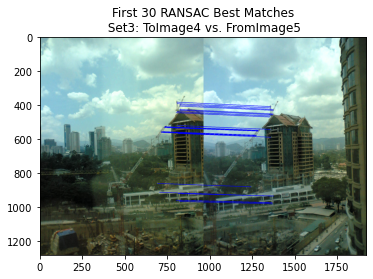


Done.




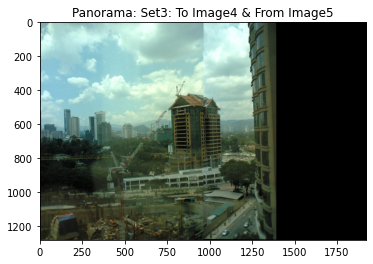

Set no  3
Image no  45
Top  1000  will be selected


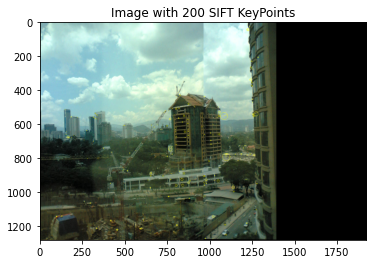

Saving SIFT features for Image999...


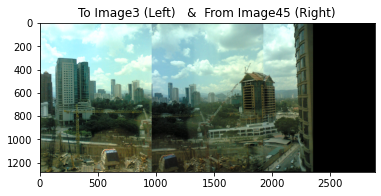


Set = Set3
From Image45 & To Image3

From Image:
Loading f45_set3.mat ...
Loading d45_set3.mat ...

To Image:
Loading f3_set3.mat ...
Loading d3_set3.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


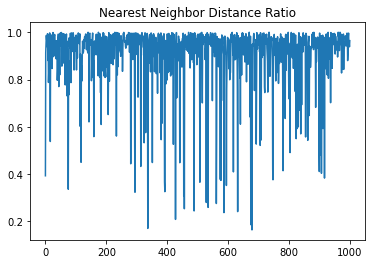

Finding good keypoints based on NNDR ...
Drawing good matches from Image45 to Image3...


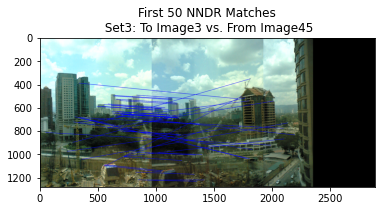


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  46

Best Affine Transformation 
 [[ 1.00392536e+00 -2.82231504e-02  4.84782879e+02]
 [ 5.41192767e-03  9.99942555e-01 -3.34771425e+01]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 1.00189984e+00 -2.46366185e-02  4.82726994e+02]
 [ 5.77496188e-04  1.00132420e+00 -3.26683190e+01]]


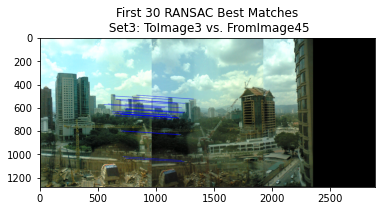


Done.




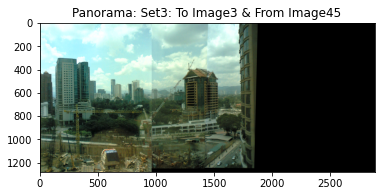

Set no  3
Image no  345
Top  1000  will be selected


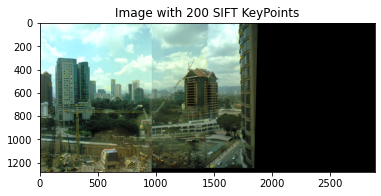

Saving SIFT features for Image999...


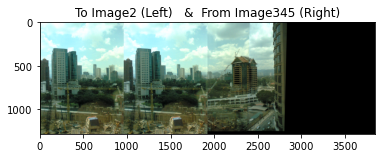


Set = Set3
From Image345 & To Image2

From Image:
Loading f345_set3.mat ...
Loading d345_set3.mat ...

To Image:
Loading f2_set3.mat ...
Loading d2_set3.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


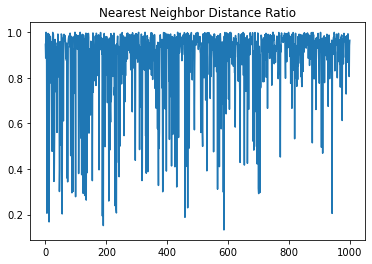

Finding good keypoints based on NNDR ...
Drawing good matches from Image345 to Image2...


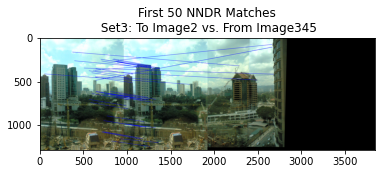


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  54

Best Affine Transformation 
 [[ 9.81077423e-01 -2.46892726e-03  5.38374123e+02]
 [ 2.57762556e-02  9.74940171e-01 -5.30526729e+01]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 9.84198294e-01 -7.36276775e-04  5.36364387e+02]
 [ 1.78457521e-02  9.75542062e-01 -5.27122830e+01]]


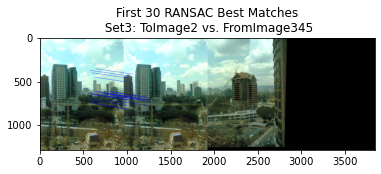


Done.




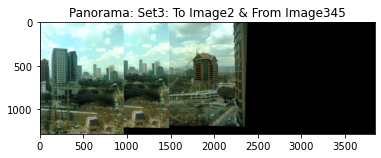

Set no  3
Image no  2345
Top  1000  will be selected


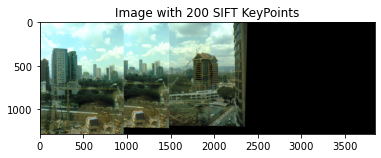

Saving SIFT features for Image999...


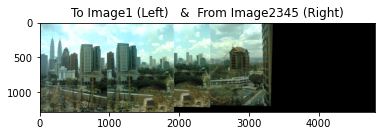


Set = Set3
From Image2345 & To Image1

From Image:
Loading f2345_set3.mat ...
Loading d2345_set3.mat ...

To Image:
Loading f1_set3.mat ...
Loading d1_set3.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


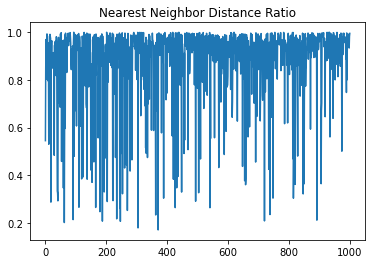

Finding good keypoints based on NNDR ...
Drawing good matches from Image2345 to Image1...


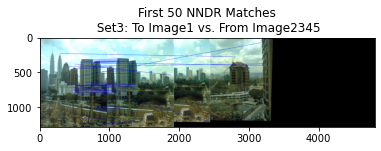


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  67

Best Affine Transformation 
 [[ 9.86242471e-01 -1.89250431e-02  4.51171958e+02]
 [ 3.24263774e-02  1.00990094e+00 -2.87690483e+00]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 9.85710325e-01 -2.07680449e-02  4.52588638e+02]
 [ 3.49217285e-02  1.00997585e+00 -3.58253049e+00]]


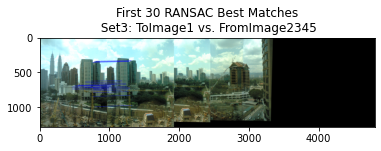


Done.




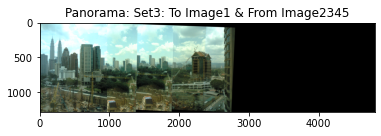

In [41]:
set_n= 3

path_1="results/Set3/image1.jpg"
path_2="results/Set3/image2.jpg"
path_3="results/Set3/image3.jpg"
path_4="results/Set3/image4.jpg"
path_5="results/Set3/image5.jpg"


image_1 = cv2.cvtColor(  cv2.imread(path_1), cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(  cv2.imread(path_2), cv2.COLOR_BGR2GRAY)
image_3 = cv2.cvtColor(  cv2.imread(path_3), cv2.COLOR_BGR2GRAY)
image_4 = cv2.cvtColor(  cv2.imread(path_4), cv2.COLOR_BGR2GRAY)
image_5 = cv2.cvtColor(  cv2.imread(path_5), cv2.COLOR_BGR2GRAY)


get_features(image_1,set_n, 1000, 1)
get_features(image_2, set_n,1000, 2)
get_features(image_3, set_n,1000, 3)
get_features(image_4, set_n,1000, 4)
get_features(image_5, set_n,1000, 5)



image_1=cv2.imread(path_1)
image_2=cv2.imread(path_2)
image_3=cv2.imread(path_3)
image_4=cv2.imread(path_4)
image_5=cv2.imread(path_5)

i_from = 5# From Image
i_to   = 4   # To Image

trans="Affine"
top_select_matches=50


from_img = image_5
to_img = image_4

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)
#########################-------------------other half-----------------###################################
i_from = 45# From Image
i_to   = 3   # To Image

get_features(warped,set_n, 1000, 45)
trans="Affine"
top_select_matches=50


from_img = warped
to_img = image_3

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)
#########################-------------------other half-----------------###################################
i_from = 345# From Image
i_to   = 2   # To Image

get_features(warped,set_n, 1000, 345)
trans="Affine"
top_select_matches=50


from_img = warped
to_img = image_3

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)
#########################-------------------other half-----------------###################################
i_from = 2345# From Image
i_to   = 1   # To Image

get_features(warped,set_n, 1000, 2345)
trans="Affine"
top_select_matches=50


from_img = warped
to_img = image_1

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)

# Set 4

Set no  4
Image no  1
Top  1000  will be selected


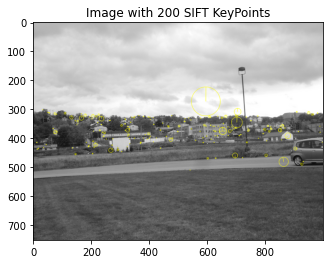

Saving SIFT features for Image999...
Set no  4
Image no  2
Top  1000  will be selected


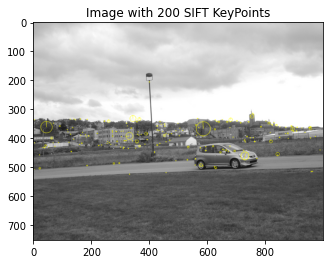

Saving SIFT features for Image999...
Set no  4
Image no  3
Top  1000  will be selected


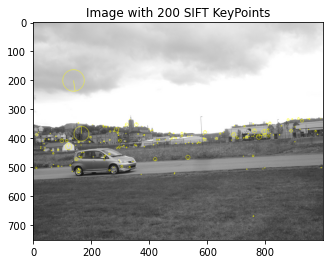

Saving SIFT features for Image999...


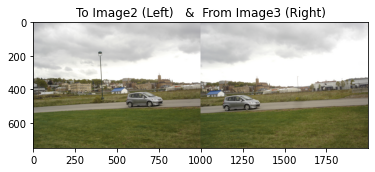


Set = Set4
From Image3 & To Image2

From Image:
Loading f3_set4.mat ...
Loading d3_set4.mat ...

To Image:
Loading f2_set4.mat ...
Loading d2_set4.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


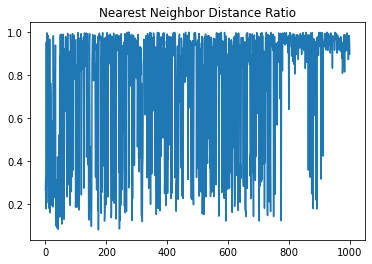

Finding good keypoints based on NNDR ...
Drawing good matches from Image3 to Image2...


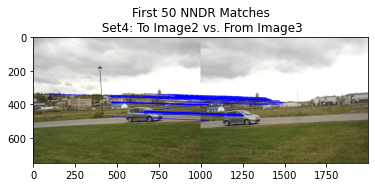


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  173

Best Affine Transformation 
 [[ 9.56373620e-01 -1.50142607e-03  4.30096721e+02]
 [-1.03001521e-02  9.89187796e-01 -1.12033433e+01]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 9.56987938e-01  1.74515216e-03  4.28596158e+02]
 [-7.74162803e-03  9.84964424e-01 -1.01197828e+01]]


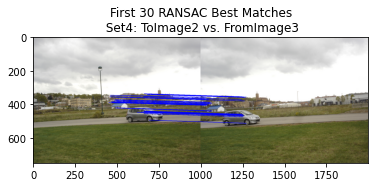


Done.




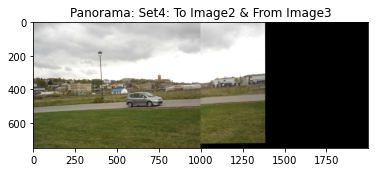

Set no  4
Image no  23
Top  1000  will be selected


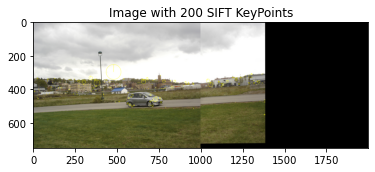

Saving SIFT features for Image999...


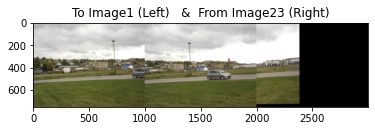


Set = Set4
From Image23 & To Image1

From Image:
Loading f23_set4.mat ...
Loading d23_set4.mat ...

To Image:
Loading f1_set4.mat ...
Loading d1_set4.mat ...

There are 1000 SIFT descriptors/keypoints in each image.

Finding l2 distance between ith descriptor of 'From' image and jth descriptor of 'To' image...


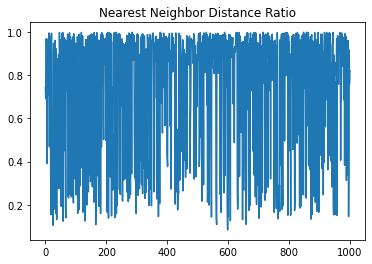

Finding good keypoints based on NNDR ...
Drawing good matches from Image23 to Image1...


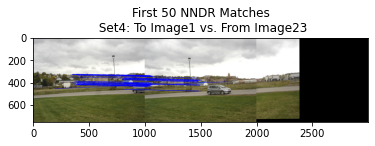


Done.


RANSAC : No. of Iterations =  1000
Selecting 3 random points from good keypoints in each iteration...
Searching for maximum number of inliers ...
Maximum Number of Inliers :  196

Best Affine Transformation 
 [[ 9.51653146e-01  2.04039185e-02  3.29486257e+02]
 [-6.37697005e-03  9.51358838e-01  5.18291061e+00]]

Using maximum number of max inliers to recover affine transformation ...

Affine Transformation Obtained from Maximum Inliers 
 [[ 9.51952222e-01  2.45854845e-02  3.27346380e+02]
 [-1.07434812e-02  9.65203762e-01  2.70535052e-01]]


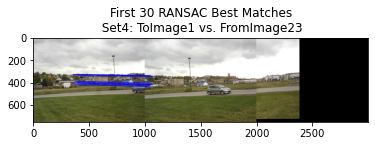


Done.




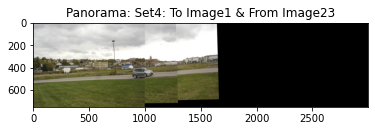

In [43]:
set_n= 4

path_1="results/Set4/image1.jpg"
path_2="results/Set4/image2.jpg"
path_3="results/Set4/image3.jpg"

image_1 = cv2.cvtColor(  cv2.imread(path_1), cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(  cv2.imread(path_2), cv2.COLOR_BGR2GRAY)
image_3 = cv2.cvtColor(  cv2.imread(path_3), cv2.COLOR_BGR2GRAY)


get_features(image_1,set_n, 1000, 1)
get_features(image_2, set_n,1000, 2)
get_features(image_3, set_n,1000, 3)


image_2=cv2.imread(path_2)
image_1=cv2.imread(path_1)
image_3=cv2.imread(path_3)

i_from = 3# From Image
i_to   = 2   # To Image

trans="Affine"
top_select_matches=50


from_img = image_3
to_img = image_2

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)
#########################-------------------other half-----------------###################################
i_from = 23# From Image
i_to   = 1   # To Image

get_features(warped,set_n, 1000, 23)
trans="Affine"
top_select_matches=50


from_img = warped
to_img = image_1

combined_img = np.concatenate((to_img, from_img) , axis=1)
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.title("To Image"+str(i_to) +  " (Left)   &  From Image"+str(i_from) + " (Right)" )
plt.show()


from_good_kpts , to_good_kpts = find_and_draw_matches(from_img , to_img , set_n , i_from , i_to ,  top_select_matches)

select_best_matches = 30
iters= 1000

T=  ransac(from_img , to_img , from_good_kpts ,  to_good_kpts , i_from , i_to , iters , select_best_matches , trans )

warped=make_panorama(from_img , to_img , T ,  set_n ,  i_from , i_to, trans)